# This notebook was inspired by an AQR paper on value and momentum strategies: https://www.aqr.com/Insights/Research/Journal-Article/The-Interaction-of-Value-and-Momentum-Strategies

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import datetime
import json
import statsmodels.api as sm
import math

In [2]:
assets_df = pd.read_csv('data/assets_data.csv')
assets_df.head()

,Adj Close: A,Adj Close: AA,Adj Close: AAP,Adj Close: AB,Adj Close: ABB,Adj Close: ABC,Adj Close: ABEV,Adj Close: ABG,Adj Close: ABT,Adj Close: ACM,...,Volume: X,Volume: XOM,Volume: XPO,Volume: YPF,Volume: YUM,Volume: ZBH,Month,Day,Year,Date
0,19.640221,35.237850,37.049263,9.560408,12.084814,21.653866,2.183233,11.78,19.265387,27.797506,...,8529900.0,19985700,69683.0,3600.0,2844734.0,607906.0,12,29,2009,2009-12-29
1,20.138828,35.831375,37.276485,9.712654,12.072253,21.604593,2.174173,11.81,19.364799,27.402517,...,8010200.0,19860600,18722.0,2600.0,1886196.0,594413.0,12,30,2009,2009-12-30
2,20.119404,35.435684,36.794739,9.723031,11.996881,21.407518,2.172915,11.53,19.169523,27.155645,...,3589500.0,18852300,36648.0,11300.0,1790217.0,579169.0,12,31,2009,2009-12-31
3,20.268343,36.600750,36.703854,9.826839,12.336060,21.867371,2.264763,11.83,19.336399,27.797506,...,10339400.0,27809100,28336.0,5100.0,2962274.0,805872.0,1,4,2010,2010-01-04
4,20.048174,35.457676,36.485683,9.816462,12.417715,21.711342,2.249161,12.39,19.180187,28.103622,...,9003200.0,30174700,44744.0,5300.0,3298757.0,1769643.0,1,5,2010,2010-01-05


In [3]:
symbols = []
cols = assets_df.columns
for col in cols:
    if 'Adj Close' not in col:
        break
    else:
        symbols.append(col.split(': ')[1])


In [18]:
cats = []
for col in cols:
    split = col.split(': ')
    if split[0] not in cats:
        cats.append(split[0])
print(cats)

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Month', 'Day', 'Year', 'Date']


In [4]:
def return_quintile_list(l):
    #l is numeric, unordered list
    new_l = l[:]
    argsort = np.argsort(np.array(l))
    new_l.sort()
    length = len(new_l)
    mod = length % 5
    quintile_base_sz = math.floor(length/5)
    quintiles = []
    idx_quintiles = []
    i = 0
    start_idx = 0
    while i < 5:
        if mod != 0:
            add = quintile_base_sz+1
            mod-=1
        else:
            add = quintile_base_sz
        quintiles.append(new_l[start_idx:start_idx+add])
        idx_quintiles.append(argsort[start_idx:start_idx+add])
        start_idx+=add
        i+=1
    return quintiles, idx_quintiles

In [5]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}

for s in symbols:
    symbol_monthly_ret_dict[s] = []

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(6,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 6

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/6)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)
        
        
    

# In the plot below, quintiles are formed based on the average monthly returns over the preceding 6 months; from these quintiles, equal weighted portfolios are constructed and the portfolio's next monthly return is plotted

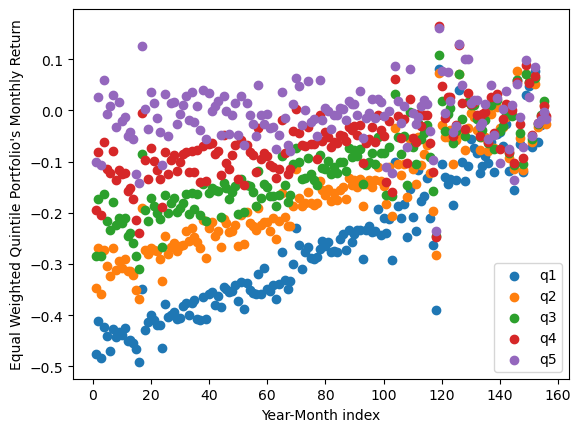

In [6]:
x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

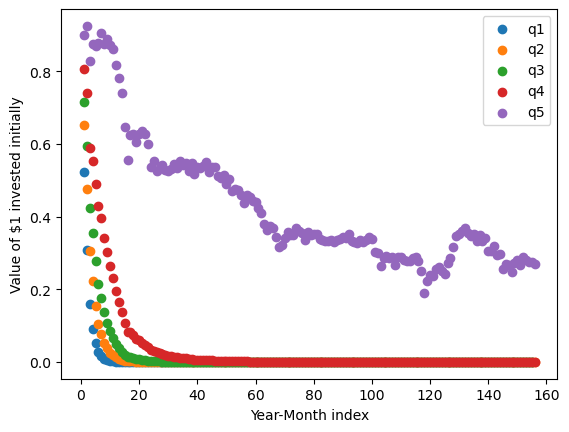

In [8]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# Repeat above analysis with lookback period of 12 months instead of 6 months

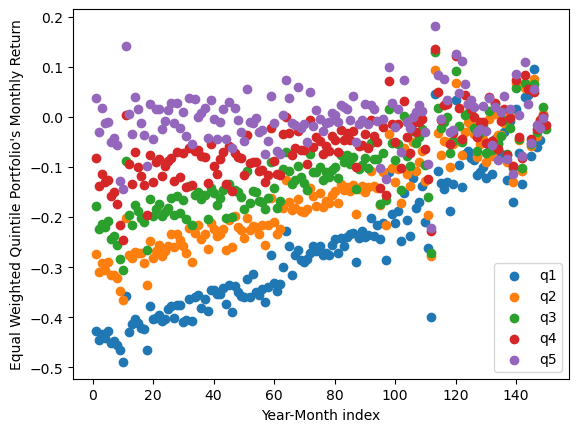

In [10]:
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(12,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 12

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/12)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

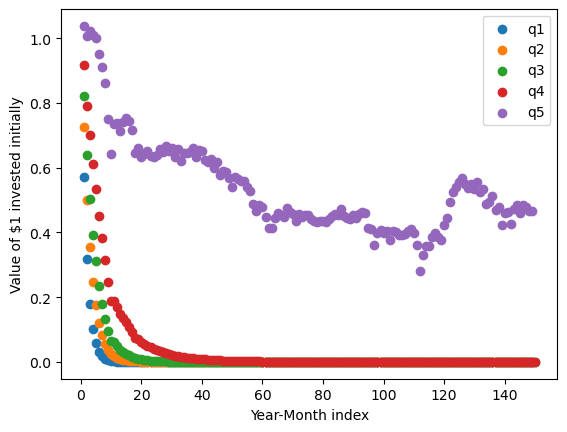

In [11]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# Repeat above analysis with lookback period of 1 month instead of 6 months

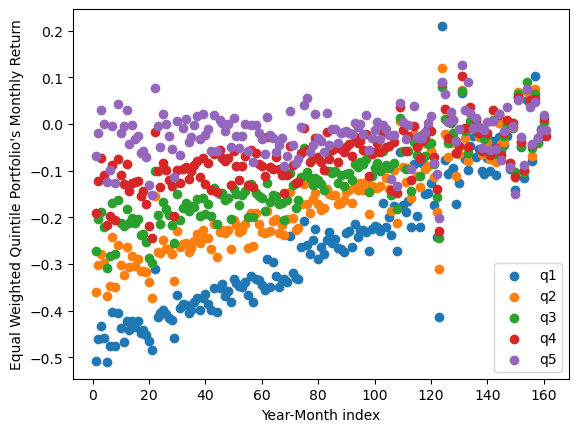

In [12]:
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(1,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 1

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/1)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

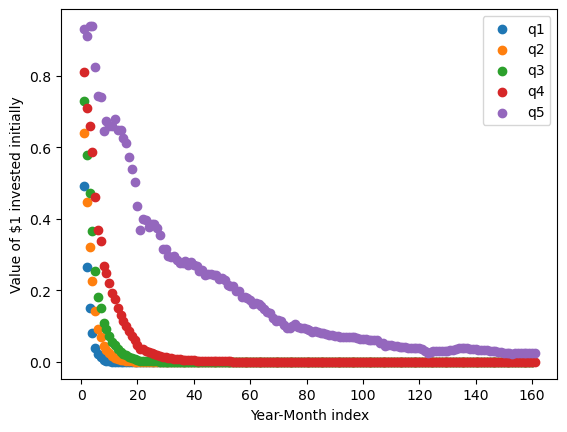

In [13]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# Repeat above analysis with lookback period of 3 months instead of 1 year

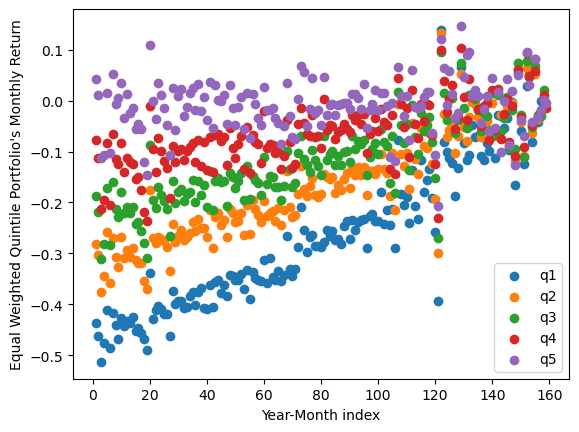

In [14]:
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(3,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 3

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/3)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()

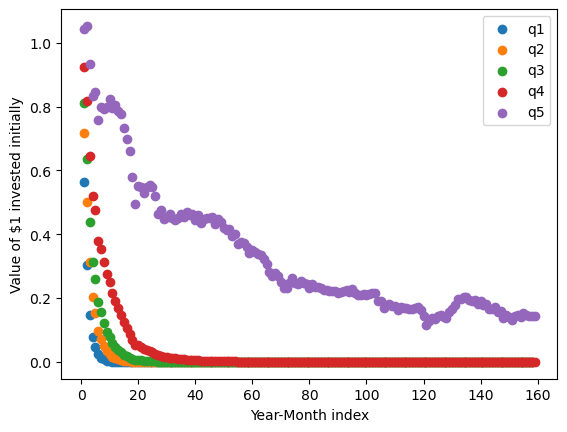

In [15]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# Repeat above analysis with lookback period of 6 months, excluding most recent month

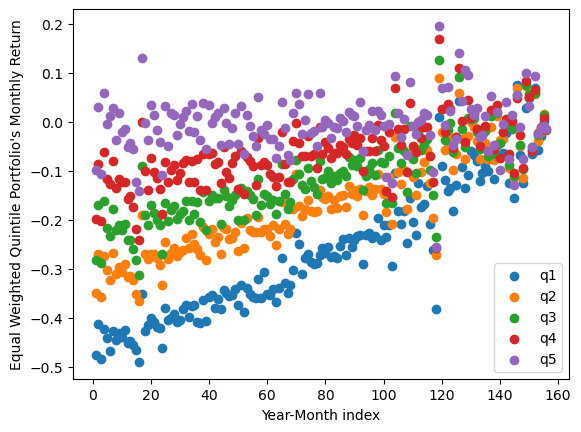

In [16]:
lookback_months = 6
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(lookback_months,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - (lookback_months)

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:ante_six_it+(lookback_months-1)])/(lookback_months-1))
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()
        

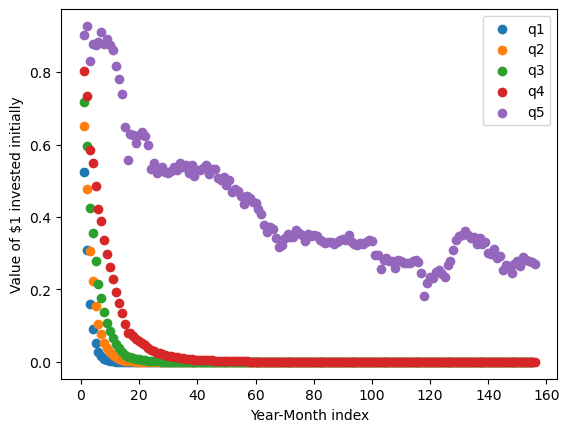

In [17]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# Repeat above analysis with lookback period of 12 months, excluding most recent month

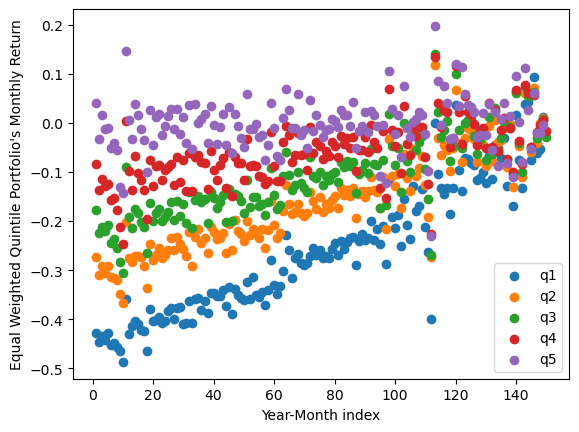

In [18]:
lookback_months = 12
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(lookback_months,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - (lookback_months)

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:ante_six_it+(lookback_months-1)])/(lookback_months-1))
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
plt.scatter(x,q2_ret,label='q2')
plt.scatter(x,q3_ret,label='q3')
plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()
        

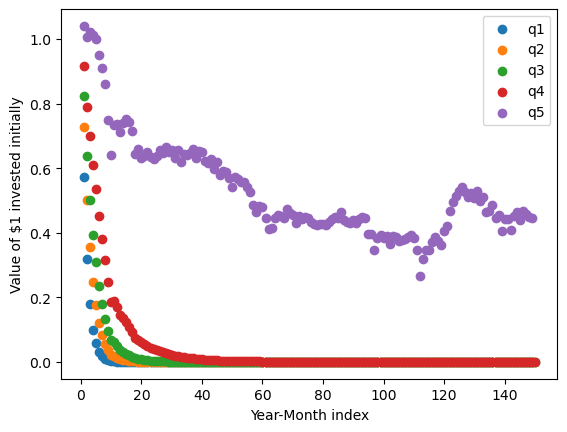

In [19]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# Repeat above analysis with lookback period of 3 months, excluding most recent month

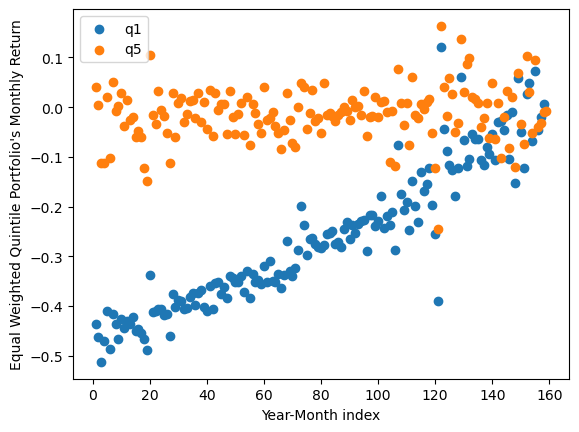

In [20]:
lookback_months = 3
q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(lookback_months,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - (lookback_months)

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:ante_six_it+(lookback_months-1)])/(lookback_months-1))
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = []
        for element in idx_quintiles[q]:
            equities.append(symbols[element])
            
        ret_sum = 0
        for company in equities:
            ret_sum += symbol_monthly_ret_dict[company][key_it]
        avg_ret = ret_sum/len(equities)
        if q == 0:
            q1_ret.append(avg_ret)
        elif q==1:
            q2_ret.append(avg_ret)
        elif q==2:
            q3_ret.append(avg_ret)
        elif q==3:
            q4_ret.append(avg_ret)
        else:
            q5_ret.append(avg_ret)

x = np.arange(1,len(q1_ret)+1)
plt.scatter(x,q1_ret,label='q1')
#plt.scatter(x,q2_ret,label='q2')
#plt.scatter(x,q3_ret,label='q3')
#plt.scatter(x,q4_ret,label='q4')
plt.scatter(x,q5_ret,label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.legend()
        

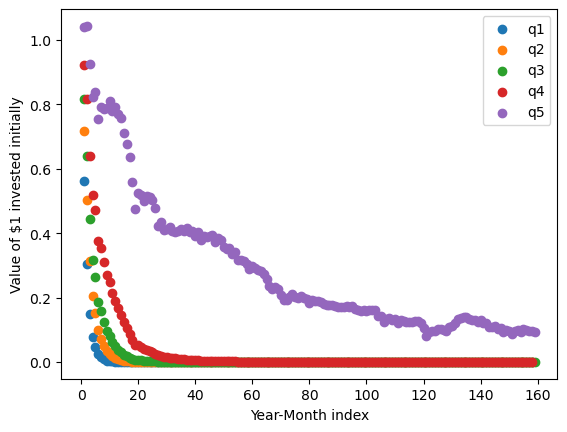

In [21]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# I believe that the equal weighting of the portfolios of each quintile is biasing the returns negatively. Choose a lookback period and current market cap's as an estimate of market weight in recent years to construct value weighted portfolios for each quintile.

lookback period of 6 months

In [26]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}
mc_dict = {}
for s in symbols:
    symbol_monthly_ret_dict[s] = []
    mc_dict[s] = yf.Ticker(s).fast_info['marketCap']

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret = []
q2_ret = []
q3_ret = []
q4_ret = []
q5_ret = []

for key_it in range(len(keys)-36,len(keys)):
    #loop thru every month, year combination after a 6 month buffer
    ante_six_it = key_it - 6

    six_month_rets = []
    #for every company, add the average monthly return for the past 6 months to. a. list
    
    for s in symbols:
        six_month_rets.append(sum(symbol_monthly_ret_dict[s][ante_six_it:key_it])/6)
        
    quintiles, idx_quintiles = return_quintile_list(six_month_rets) #sort list into quintiles and index-based quintiles
    
    for q in range(5):
        #for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
        #each of those companies, find the monthly return for the. current month, year combination and
        #average it over the quintile
        
        equities = {} #map symbol to market cap first and then value weight
        for element in idx_quintiles[q]:
            equities[symbols[element]] = mc_dict[symbols[element]]
         
        mc_sum = sum(list(equities.values()))
        for element in idx_quintiles[q]:
            equities[symbols[element]] = equities[symbols[element]]/mc_sum
            
        ret_sum = 0
        for company in equities.keys():
            ret_sum += (equities[company]*symbol_monthly_ret_dict[company][key_it])
        if q == 0:
            q1_ret.append(ret_sum)
        elif q==1:
            q2_ret.append(ret_sum)
        elif q==2:
            q3_ret.append(ret_sum)
        elif q==3:
            q4_ret.append(ret_sum)
        else:
            q5_ret.append(ret_sum)
        
        
    

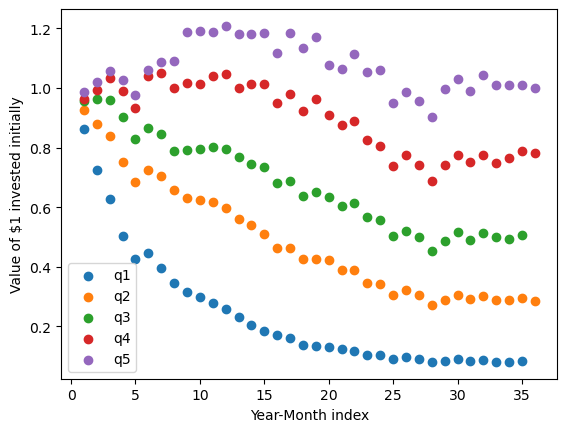

In [27]:
x = []
for i in range(len(q1_ret)):
    x.append(i+1)

q1_pv = [1]
q2_pv = [1]
q3_pv = [1]
q4_pv = [1]
q5_pv = [1]

for mr in q1_ret:
    q1_pv.append(q1_pv[-1]*(1+mr))
for mr in q2_ret:
    q2_pv.append(q2_pv[-1]*(1+mr))
for mr in q3_ret:
    q3_pv.append(q3_pv[-1]*(1+mr))
for mr in q4_ret:
    q4_pv.append(q4_pv[-1]*(1+mr))
for mr in q5_ret:
    q5_pv.append(q5_pv[-1]*(1+mr))

plt.scatter(x,q1_pv[1:],label='q1')
plt.scatter(x,q2_pv[1:],label='q2')
plt.scatter(x,q3_pv[1:],label='q3')
plt.scatter(x,q4_pv[1:],label='q4')
plt.scatter(x,q5_pv[1:],label='q5')
plt.xlabel('Year-Month index')
plt.ylabel('Value of $1 invested initially')
plt.legend()

# In this case, we create quintile portfolios based on value weight. The 'winners' portfolio perform better than

# We can repeat a similar analysis while controlling for beta

In [8]:
with open('data/monthly_beta.json', 'r') as fp:
    monthly_beta_dict = json.load(fp)

In [9]:
def get_lowest_and_upper_quintile_beta(bdict,month,year, s):
    symbols_to_beta_dict = bdict[str(year)][str(month)]
    symbols = s
    beta_list = []
    for sym in symbols:
        beta_list.append(symbols_to_beta_dict[sym])
    quintiles, index_quintiles = return_quintile_list(beta_list)
    equity_quintiles = []
    for q in range(5):
        cur_q = index_quintiles[q]
        l = []
        for idx in cur_q:
            l.append(symbols[idx])
        equity_quintiles.append(l[:])
    return equity_quintiles

In [10]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}
lookback = 6

for s in symbols:
    symbol_monthly_ret_dict[s] = []

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret_lb = []
q2_ret_lb = []
q3_ret_lb = []
q4_ret_lb = []
q5_ret_lb = []

q1_ret_hb = []
q2_ret_hb = []
q3_ret_hb = []
q4_ret_hb = []
q5_ret_hb = []

for year in range(2011,2024):
    end_month = 13
    if year == 2023:
        end_month = 5
    for month in range(1,end_month):
        #loop thru months and years
        
        #retrieve lowest quintile and highest quintile stocks wrt beta for month/year at hand
        stock_quintiles = get_lowest_and_upper_quintile_beta(monthly_beta_dict,month,year,symbols)
        low_beta = stock_quintiles[0]
        high_beta = stock_quintiles[4]
        
        
        lb_six_month_rets = []
        hb_six_month_rets = []
        key_it = keys.index((year,month))
        
        #append for each stock, average monthly return over lookback months period
        for s in low_beta:
            lb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        for s in high_beta:
            hb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        
        
        #get quintiles for low and high beta past lookback months' average monthly returns 
        lb_quintiles, lb_idx_quintiles = return_quintile_list(lb_six_month_rets)
        hb_quintiles, hb_idx_quintiles = return_quintile_list(hb_six_month_rets)
        
        for q in range(5):
            
            #for low beta companies, for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
            #each of those companies, find the monthly return for the current month, year combination and
            #average it over the quintile

            lb_equities = [] #will contain companies belonging to qth quintile of low beta stocks
            for element in lb_idx_quintiles[q]:
                lb_equities.append(low_beta[element])
            
            hb_equities = []
            for element in hb_idx_quintiles[q]:
                hb_equities.append(high_beta[element])

            lb_ret_sum = 0
            for company in lb_equities:
                lb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            lb_avg_ret = lb_ret_sum/len(lb_equities)
            
            hb_ret_sum = 0
            for company in hb_equities:
                hb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            hb_avg_ret = hb_ret_sum/len(hb_equities)
            
            
            if q == 0:
                q1_ret_lb.append(lb_avg_ret)
                q1_ret_hb.append(hb_avg_ret)
            elif q==1:
                q2_ret_lb.append(lb_avg_ret)
                q2_ret_hb.append(hb_avg_ret)
            elif q==2:
                q3_ret_lb.append(lb_avg_ret)
                q3_ret_hb.append(hb_avg_ret)
            elif q==3:
                q4_ret_lb.append(lb_avg_ret)
                q4_ret_hb.append(hb_avg_ret)
            else:
                q5_ret_lb.append(lb_avg_ret)
                q5_ret_hb.append(hb_avg_ret)


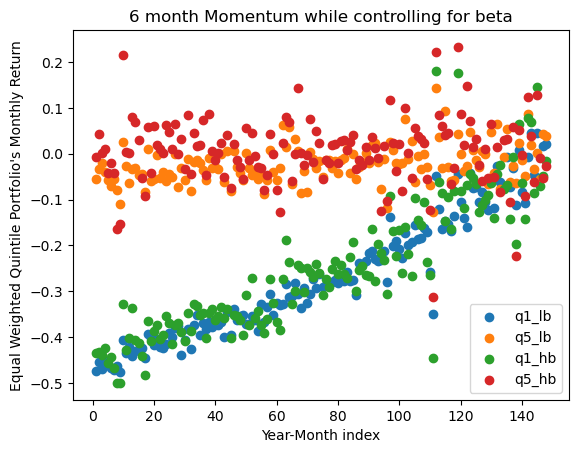

In [11]:
x = np.arange(1,len(q1_ret_lb)+1)
plt.scatter(x,q1_ret_lb,label='q1_lb')
plt.scatter(x,q5_ret_lb,label='q5_lb')
plt.scatter(x,q1_ret_hb,label='q1_hb')
plt.scatter(x,q5_ret_hb,label='q5_hb')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.title('6 month Momentum while controlling for beta')
plt.legend()


# Control for beta and repeat analysis with different lookback period

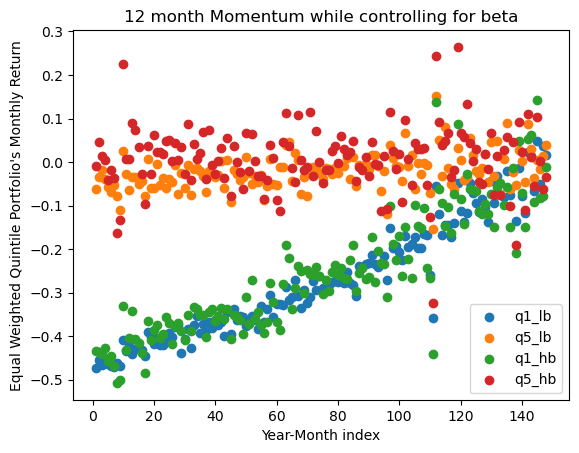

In [12]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}
lookback = 12

for s in symbols:
    symbol_monthly_ret_dict[s] = []

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret_lb = []
q2_ret_lb = []
q3_ret_lb = []
q4_ret_lb = []
q5_ret_lb = []

q1_ret_hb = []
q2_ret_hb = []
q3_ret_hb = []
q4_ret_hb = []
q5_ret_hb = []

for year in range(2011,2024):
    end_month = 13
    if year == 2023:
        end_month = 5
    for month in range(1,end_month):
        #loop thru months and years
        
        #retrieve lowest quintile and highest quintile stocks wrt beta for month/year at hand
        stock_quintiles = get_lowest_and_upper_quintile_beta(monthly_beta_dict,month,year,symbols)
        low_beta = stock_quintiles[0]
        high_beta = stock_quintiles[4]
        
        
        lb_six_month_rets = []
        hb_six_month_rets = []
        key_it = keys.index((year,month))
        
        #append for each stock, average monthly return over lookback months period
        for s in low_beta:
            lb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        for s in high_beta:
            hb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        
        
        #get quintiles for low and high beta past lookback months' average monthly returns 
        lb_quintiles, lb_idx_quintiles = return_quintile_list(lb_six_month_rets)
        hb_quintiles, hb_idx_quintiles = return_quintile_list(hb_six_month_rets)
        
        for q in range(5):
            
            #for low beta companies, for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
            #each of those companies, find the monthly return for the current month, year combination and
            #average it over the quintile

            lb_equities = [] #will contain companies belonging to qth quintile of low beta stocks
            for element in lb_idx_quintiles[q]:
                lb_equities.append(low_beta[element])
            
            hb_equities = []
            for element in hb_idx_quintiles[q]:
                hb_equities.append(high_beta[element])

            lb_ret_sum = 0
            for company in lb_equities:
                lb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            lb_avg_ret = lb_ret_sum/len(lb_equities)
            
            hb_ret_sum = 0
            for company in hb_equities:
                hb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            hb_avg_ret = hb_ret_sum/len(hb_equities)
            
            
            if q == 0:
                q1_ret_lb.append(lb_avg_ret)
                q1_ret_hb.append(hb_avg_ret)
            elif q==1:
                q2_ret_lb.append(lb_avg_ret)
                q2_ret_hb.append(hb_avg_ret)
            elif q==2:
                q3_ret_lb.append(lb_avg_ret)
                q3_ret_hb.append(hb_avg_ret)
            elif q==3:
                q4_ret_lb.append(lb_avg_ret)
                q4_ret_hb.append(hb_avg_ret)
            else:
                q5_ret_lb.append(lb_avg_ret)
                q5_ret_hb.append(hb_avg_ret)
                
x = np.arange(1,len(q1_ret_lb)+1)
plt.scatter(x,q1_ret_lb,label='q1_lb')
plt.scatter(x,q5_ret_lb,label='q5_lb')
plt.scatter(x,q1_ret_hb,label='q1_hb')
plt.scatter(x,q5_ret_hb,label='q5_hb')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.title('12 month Momentum while controlling for beta')
plt.legend()




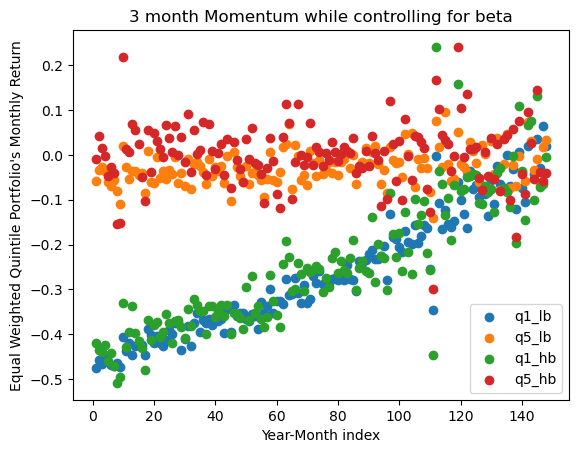

In [13]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}
lookback = 3

for s in symbols:
    symbol_monthly_ret_dict[s] = []

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret_lb = []
q2_ret_lb = []
q3_ret_lb = []
q4_ret_lb = []
q5_ret_lb = []

q1_ret_hb = []
q2_ret_hb = []
q3_ret_hb = []
q4_ret_hb = []
q5_ret_hb = []

for year in range(2011,2024):
    end_month = 13
    if year == 2023:
        end_month = 5
    for month in range(1,end_month):
        #loop thru months and years
        
        #retrieve lowest quintile and highest quintile stocks wrt beta for month/year at hand
        stock_quintiles = get_lowest_and_upper_quintile_beta(monthly_beta_dict,month,year,symbols)
        low_beta = stock_quintiles[0]
        high_beta = stock_quintiles[4]
        
        
        lb_six_month_rets = []
        hb_six_month_rets = []
        key_it = keys.index((year,month))
        
        #append for each stock, average monthly return over lookback months period
        for s in low_beta:
            lb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        for s in high_beta:
            hb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        
        
        #get quintiles for low and high beta past lookback months' average monthly returns 
        lb_quintiles, lb_idx_quintiles = return_quintile_list(lb_six_month_rets)
        hb_quintiles, hb_idx_quintiles = return_quintile_list(hb_six_month_rets)
        
        for q in range(5):
            
            #for low beta companies, for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
            #each of those companies, find the monthly return for the current month, year combination and
            #average it over the quintile

            lb_equities = [] #will contain companies belonging to qth quintile of low beta stocks
            for element in lb_idx_quintiles[q]:
                lb_equities.append(low_beta[element])
            
            hb_equities = []
            for element in hb_idx_quintiles[q]:
                hb_equities.append(high_beta[element])

            lb_ret_sum = 0
            for company in lb_equities:
                lb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            lb_avg_ret = lb_ret_sum/len(lb_equities)
            
            hb_ret_sum = 0
            for company in hb_equities:
                hb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            hb_avg_ret = hb_ret_sum/len(hb_equities)
            
            
            if q == 0:
                q1_ret_lb.append(lb_avg_ret)
                q1_ret_hb.append(hb_avg_ret)
            elif q==1:
                q2_ret_lb.append(lb_avg_ret)
                q2_ret_hb.append(hb_avg_ret)
            elif q==2:
                q3_ret_lb.append(lb_avg_ret)
                q3_ret_hb.append(hb_avg_ret)
            elif q==3:
                q4_ret_lb.append(lb_avg_ret)
                q4_ret_hb.append(hb_avg_ret)
            else:
                q5_ret_lb.append(lb_avg_ret)
                q5_ret_hb.append(hb_avg_ret)
                
x = np.arange(1,len(q1_ret_lb)+1)
plt.scatter(x,q1_ret_lb,label='q1_lb')
plt.scatter(x,q5_ret_lb,label='q5_lb')
plt.scatter(x,q1_ret_hb,label='q1_hb')
plt.scatter(x,q5_ret_hb,label='q5_hb')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.title('3 month Momentum while controlling for beta')
plt.legend()





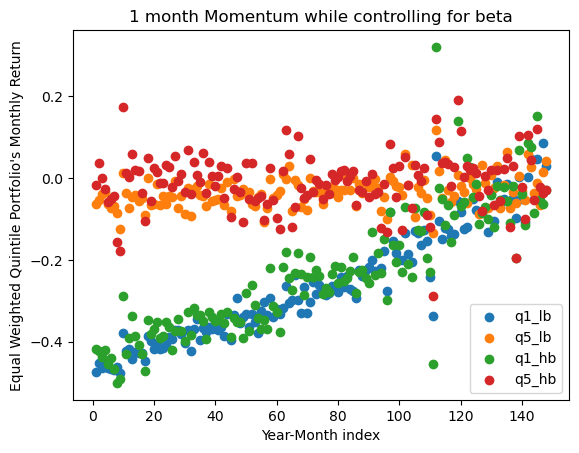

In [14]:
assets_df_gbo = assets_df.groupby(['Year','Month'])
symbol_monthly_ret_dict = {}
lookback = 1

for s in symbols:
    symbol_monthly_ret_dict[s] = []

keys = list(assets_df_gbo.groups.keys())

for key in keys:
    group = assets_df_gbo.get_group(key)
    fd = group.head(1)
    ld = group.tail(1)
    for s in symbols:
        fdopen = fd['Open: ' + s].iloc[0]
        ldclose = ld['Adj Close: ' + s].iloc[0]
        ret = (ldclose-fdopen)/fdopen
        symbol_monthly_ret_dict[s].append(ret)

q1_ret_lb = []
q2_ret_lb = []
q3_ret_lb = []
q4_ret_lb = []
q5_ret_lb = []

q1_ret_hb = []
q2_ret_hb = []
q3_ret_hb = []
q4_ret_hb = []
q5_ret_hb = []

for year in range(2011,2024):
    end_month = 13
    if year == 2023:
        end_month = 5
    for month in range(1,end_month):
        #loop thru months and years
        
        #retrieve lowest quintile and highest quintile stocks wrt beta for month/year at hand
        stock_quintiles = get_lowest_and_upper_quintile_beta(monthly_beta_dict,month,year,symbols)
        low_beta = stock_quintiles[0]
        high_beta = stock_quintiles[4]
        
        
        lb_six_month_rets = []
        hb_six_month_rets = []
        key_it = keys.index((year,month))
        
        #append for each stock, average monthly return over lookback months period
        for s in low_beta:
            lb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        for s in high_beta:
            hb_six_month_rets.append(sum(symbol_monthly_ret_dict[s][key_it-lookback:key_it])/lookback)
        
        
        #get quintiles for low and high beta past lookback months' average monthly returns 
        lb_quintiles, lb_idx_quintiles = return_quintile_list(lb_six_month_rets)
        hb_quintiles, hb_idx_quintiles = return_quintile_list(hb_six_month_rets)
        
        for q in range(5):
            
            #for low beta companies, for each of the 5 quintiles, retrieve companies corresponding to that quintile; for
            #each of those companies, find the monthly return for the current month, year combination and
            #average it over the quintile

            lb_equities = [] #will contain companies belonging to qth quintile of low beta stocks
            for element in lb_idx_quintiles[q]:
                lb_equities.append(low_beta[element])
            
            hb_equities = []
            for element in hb_idx_quintiles[q]:
                hb_equities.append(high_beta[element])

            lb_ret_sum = 0
            for company in lb_equities:
                lb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            lb_avg_ret = lb_ret_sum/len(lb_equities)
            
            hb_ret_sum = 0
            for company in hb_equities:
                hb_ret_sum += symbol_monthly_ret_dict[company][key_it]
            hb_avg_ret = hb_ret_sum/len(hb_equities)
            
            
            if q == 0:
                q1_ret_lb.append(lb_avg_ret)
                q1_ret_hb.append(hb_avg_ret)
            elif q==1:
                q2_ret_lb.append(lb_avg_ret)
                q2_ret_hb.append(hb_avg_ret)
            elif q==2:
                q3_ret_lb.append(lb_avg_ret)
                q3_ret_hb.append(hb_avg_ret)
            elif q==3:
                q4_ret_lb.append(lb_avg_ret)
                q4_ret_hb.append(hb_avg_ret)
            else:
                q5_ret_lb.append(lb_avg_ret)
                q5_ret_hb.append(hb_avg_ret)
                
x = np.arange(1,len(q1_ret_lb)+1)
plt.scatter(x,q1_ret_lb,label='q1_lb')
plt.scatter(x,q5_ret_lb,label='q5_lb')
plt.scatter(x,q1_ret_hb,label='q1_hb')
plt.scatter(x,q5_ret_hb,label='q5_hb')
plt.xlabel('Year-Month index')
plt.ylabel('Equal Weighted Quintile Portfolio\'s Monthly Return')
plt.title('1 month Momentum while controlling for beta')
plt.legend()





# In the recent months and years, the evidence that momentum can generate distinctive returns is weak according to my analysis (even when controlling for beta). Something that may have affected this analysis is that momentum was computed using averaged monthly returns over some lookback period and portfolios used to compare high momentum vs low momentum stocks were equally 